# Sinh dữ liệu

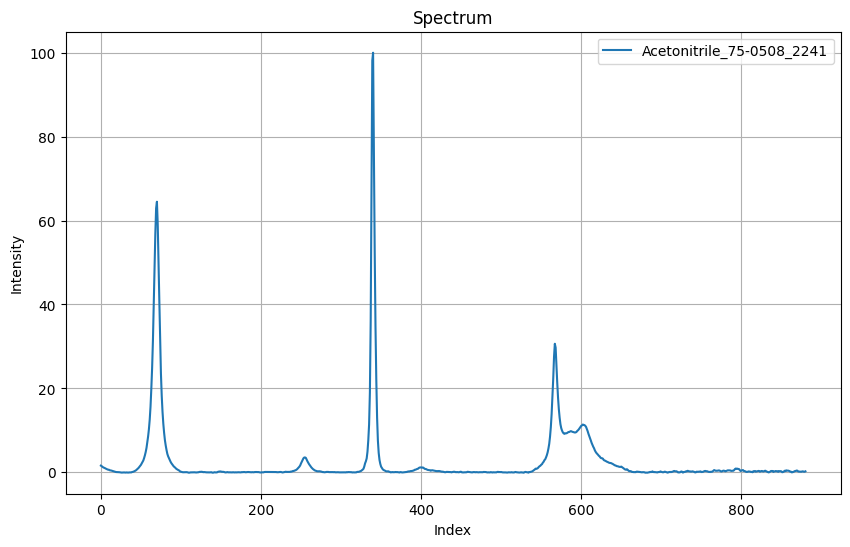

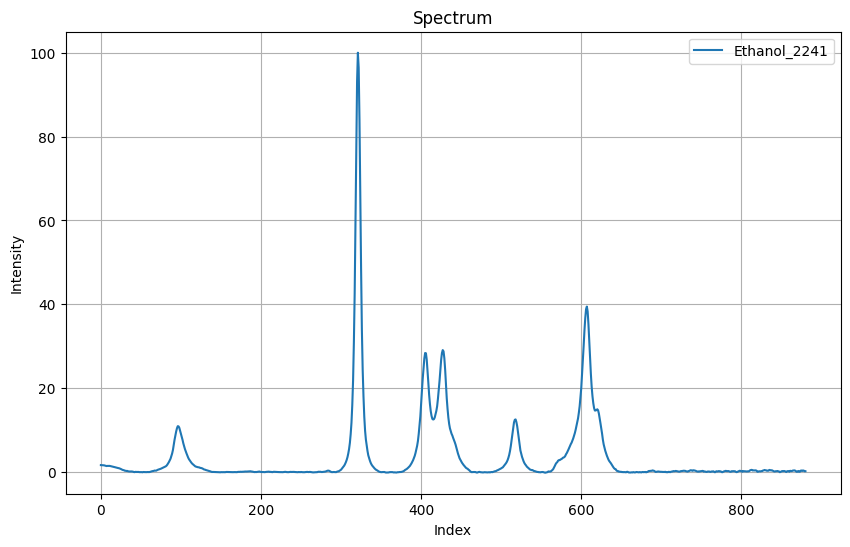

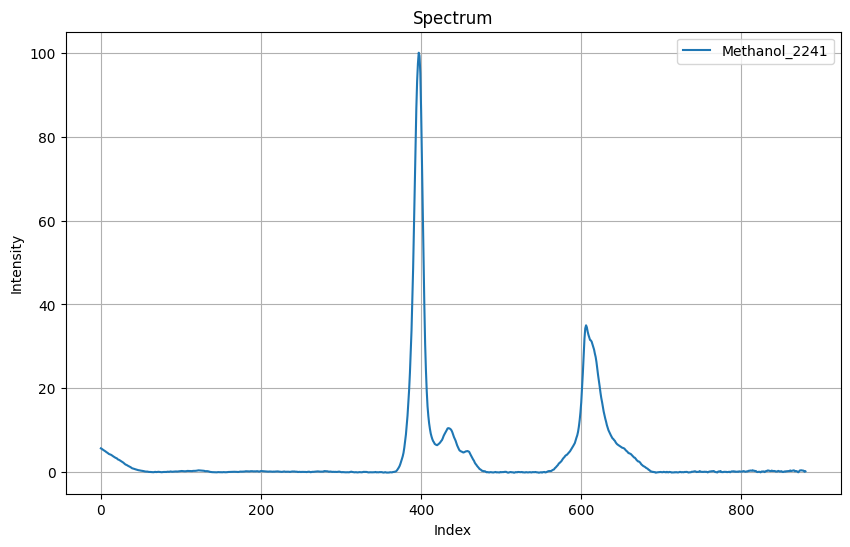

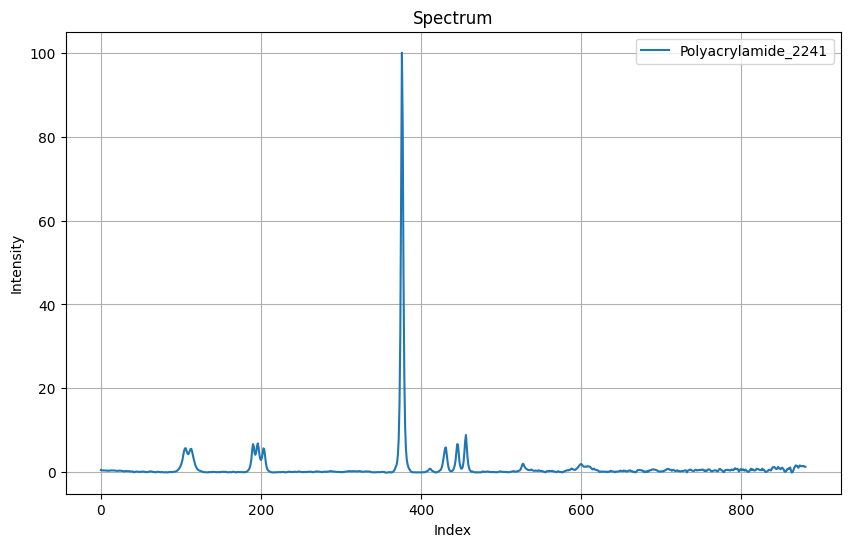

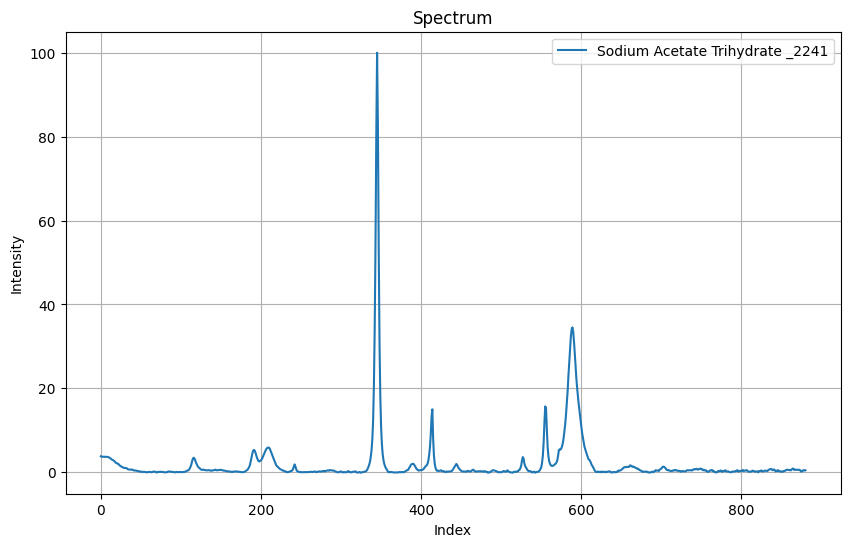

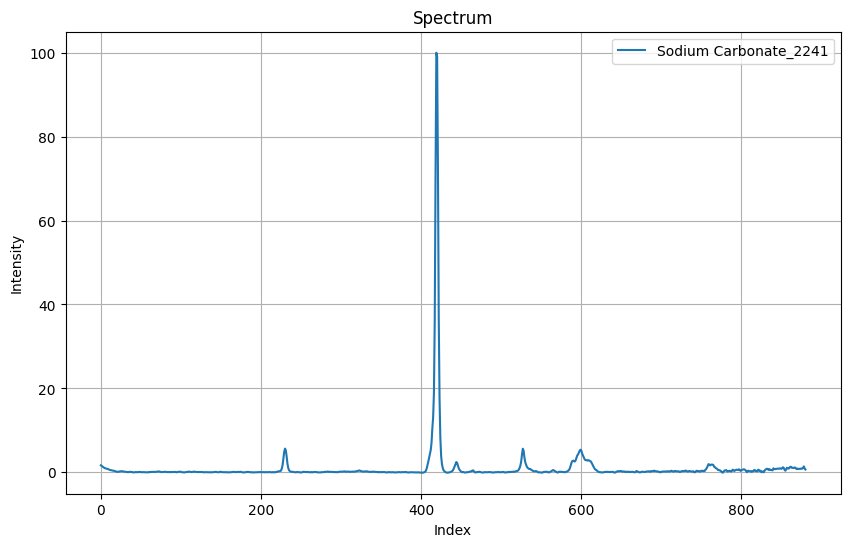

In [2]:
import tensorflow as tf
import numpy as np
from sklearn import preprocessing
from sklearn.linear_model import enet_path
from scipy.sparse import spdiags,eye,csc_matrix, diags
from scipy.sparse.linalg import spsolve
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Layer
import copy
import csv
from Model import SPP, ResUNet


# Các thuật toán denoising và baseline correction truyền thống
def WhittakerSmooth(x, lamb, w):
        m = w.shape[0]
        W = spdiags(w, 0, m, m)
        D = eye(m - 1, m, 1) - eye(m - 1, m)
        return spsolve((W + lamb * D.transpose() * D), w * x)


def airPLS(x, lamb=10, itermax=10):
        m = x.shape[0]
        w = np.ones(m)
        for i in range(itermax):
            z = WhittakerSmooth(x, lamb, w)
            d = x - z
            if sum(abs(d[d < 0])) < 0.001 * sum(abs(x)):
                break;
            w[d < 0] = np.exp(i * d[d < 0] / sum(d[d < 0]))
            w[d >= 0] = 0
        return z


def airPLS_MAT(X, lamb=10, itermax=10):
        B = X.copy()
        for i in range(X.shape[0]):
            B[i,] = airPLS(X[i,], lamb, itermax)
        return X - B

    
def WhittakerSmooth_MAT(X, lamb=1):
        C = X.copy()
        w = np.ones(X.shape[1])
        for i in range(X.shape[0]):
            C[i,] = WhittakerSmooth(X[i, :], lamb, w)
    
        return C

# Import Data
# Database
datafile0 = u'./data/database_for_Liquid_and_powder_mixture.npy'
spectrum_pure = np.load(datafile0)

# Component information of database
csv_reader = csv.reader(open(u'./data/database_for_Liquid_and_powder_mixture.csv', encoding='utf-8'))
DBcoms = [row for row in csv_reader]


spectrum_pure = WhittakerSmooth_MAT(spectrum_pure, lamb=1)
spectrum_pure = airPLS_MAT(spectrum_pure, lamb=10, itermax=10)

# Chuẩn hóa
for i in range(spectrum_pure.shape[0]):
         spectrum_pure[i, :] = spectrum_pure[i, :] / np.max(spectrum_pure[i, :]) * 100

for i, idx in enumerate(DBcoms):
        plt.figure(figsize=(10, 6))
        plt.plot(spectrum_pure[i, :], label=idx[0])
        plt.xlabel('Index')
        plt.ylabel('Intensity')
        plt.title(f'Spectrum')
        plt.legend()
        plt.grid(True)
        plt.show()

In [31]:
import numpy as np
spectrum_pure = np.load(datafile0)[:,:880]

def make_data_detect(spectrum_pure = spectrum_pure, num_samples = 15000, num_components = 6, channels = 2, length = 880, width = 1):
    for i in range(spectrum_pure.shape[0]):
        spectrum_pure[i, :] = spectrum_pure[i, :] * 10
    dataset_detect = np.zeros((num_samples, num_components, channels, length , width))
    labels = np.zeros((num_samples, num_components, 2))

    for i in range(num_samples):
            # Chọn ngẫu nhiên 2 chất pure từ tập dữ liệu chất pure
            pure_indices = np.random.choice(len(spectrum_pure), 2, replace=False)
                
            # Tính toán dữ liệu phổ mix
            c1 = np.round(np.random.uniform(0.1, 0.9), 2) # Chỉnh lại để giá trị c1 >= 0.1
            c2 = 1 - c1
            mix_spectrum = c1 * spectrum_pure[pure_indices[0]] + c2 * spectrum_pure[pure_indices[1]]
            # Chuẩn hóa
            for j in range(num_components):

                spectrum = spectrum_pure[j, :]  / np.max(spectrum_pure[j, :]) * 100
                mix_spectrum = mix_spectrum / np.max(mix_spectrum) * 100
                # Lưu trữ dữ liệu phổ mix vào dataset_mix
                dataset_detect[i, j, 0, :, :] = spectrum.reshape((880,1)) 
                dataset_detect[i, j, 1, :, :] = mix_spectrum.reshape((880,1))
        
                # Gán nhãn cho mỗi mẫu
                if j == pure_indices[0] or j == pure_indices[1]:
                    labels[i, j, :] = [0 ,1]
                else:
                    labels[i, j, :] = [1, 0]
                    
    # Kiểm tra kích thước của dataset_mix và labels
    print("Kích thước data_detect:", dataset_detect.shape)
    print("Kích thước labels:", labels.shape)
        
    # Lưu dataset_mix
    np.save('./data/dataset_detect_01104.npy', dataset_detect)
    # Lưu labels
    np.save('./data/labels_detect_01104.npy', labels)

print("ok")
make_data_detect()

ok
Kích thước data_detect: (15000, 6, 2, 880, 1)
Kích thước labels: (15000, 6, 2)


## Sinh data nhiễu dao động

In [28]:
import numpy as np
# spectrum_pure = spectrum_pure[:,:880]
spectrum_pure = np.load(datafile0)[:,:880]

def make_data_denoise(spectrum_pure = spectrum_pure, num_samples = 15000, num_components = 6, channels = 2, length = 880, width = 1):
    for i in range(spectrum_pure.shape[0]):
        spectrum_pure[i, :] = spectrum_pure[i, :] * 10
    dataset = np.zeros((num_samples, num_components, channels, length , width))
    labels = []
    
    cc = np.zeros((num_samples, num_components, 2))


    for i in range(num_samples):
            for j in range(num_components):
                label = np.zeros(num_components)
                # Chọn ngẫu nhiên 2 chất pure từ tập dữ liệu chất pure
                pure_indices = np.random.choice(len(spectrum_pure), 2, replace=False)
                label[pure_indices] = 1
                labels.append(label)
                
                # Tính toán dữ liệu phổ mix
                c1 = np.round(np.random.uniform(0.1, 0.9), 2) # Chỉnh lại để giá trị c1 >= 0.1
                c2 = 1 - c1
                mix_spectrum = c1 * spectrum_pure[pure_indices[0]] + c2 * spectrum_pure[pure_indices[1]]
                mix_spectrum_noisy = mix_spectrum + np.random.normal(0, 1, size=len(mix_spectrum))

                # Lưu trữ dữ liệu phổ mix vào dataset_mix
                mix_spectrum = mix_spectrum / np.max(mix_spectrum) * 100
                mix_spectrum_noisy = mix_spectrum_noisy / np.max(mix_spectrum_noisy) * 100

                dataset[i, j, 0, :, :] = mix_spectrum.reshape((880,1))
                dataset[i, j, 1, :, :] = mix_spectrum_noisy.reshape((880,1))
        
                cc[i, j, :] = [c1, c2]
    labels = np.array(labels)
            
    # Kiểm tra kích thước của dataset_mix và labels
    print("Kích thước dataset_mix:", dataset.shape)
    print("Kích thước labels:", labels.shape)
    print("Kích thước cc", cc.shape)

    # Lưu dataset_mix
    np.save('./data/dataset_noise_01104.npy', dataset)
    
    # Lưu labels
    np.save('./data/labels_noise_01104.npy', labels)
    
    # Lưu cc
    np.save('./data/cc_noise_01104.npy', cc)

make_data_denoise()

Kích thước dataset_mix: (15000, 6, 2, 880, 1)
Kích thước labels: (90000, 6)
Kích thước cc (15000, 6, 2)


## Sinh data test

In [29]:
import numpy as np
spectrum_pure = np.load(datafile0)[:,:880]

# Hàm tạo dữ liệu thử nghiệm
def make_test_data(spectrum_pure = spectrum_pure, num_samples = 50, num_components = 6, channels = 2, length = 880, width = 1):
    for i in range(spectrum_pure.shape[0]):
        spectrum_pure[i, :] = spectrum_pure[i, :] * 10
    dataset = np.zeros((num_samples, num_components, channels, length , width))
    labels = []
    
    cc = np.zeros((num_samples, num_components, 6))


    for i in range(num_samples):
            for j in range(num_components):
                label = np.zeros(num_components)
                # Chọn ngẫu nhiên 2 chất pure từ tập dữ liệu chất pure
                pure_indices = np.random.choice(len(spectrum_pure), 2, replace=False)
                label[pure_indices] = 1
                labels.append(label)
                
                # Tính toán dữ liệu phổ mix
                c1 = np.round(np.random.uniform(0.1, 0.9), 2) # Chỉnh lại để giá trị c1 >= 0.1
                c2 = 1 - c1
                mix_spectrum = c1 * spectrum_pure[pure_indices[0]] + c2 * spectrum_pure[pure_indices[1]]

                mix_spectrum_noisy = mix_spectrum + np.random.normal(0, 1, size=len(mix_spectrum))

                # Lưu trữ dữ liệu phổ mix vào dataset_mix
                mix_spectrum = mix_spectrum / np.max(mix_spectrum) * 100
                mix_spectrum_noisy = mix_spectrum_noisy / np.max(mix_spectrum_noisy) * 100
                
                dataset[i, j, 0, :, :] = mix_spectrum.reshape((880,1))
                dataset[i, j, 1, :, :] = mix_spectrum_noisy.reshape((880,1))
                cc_array = np.zeros(6)
                cc_array[pure_indices[0]] = c1
                cc_array[pure_indices[1]] = c2
                cc[i, j, :] = cc_array
            
    labels = np.array(labels)
            
    # Kiểm tra kích thước của dataset_mix và labels
    print("Kích thước dataset test:", dataset.shape)
    print("Kích thước labels test:", labels.shape)
    print("Kích thước cc test", cc.shape)

    # Lưu dataset_mix
    np.save('./data/dataset_test_01104.npy', dataset)
    
    # Lưu labels
    np.save('./data/labels_test_01104.npy', labels)
    
    # Lưu cc
    np.save('./data/cc_test_01104.npy', cc)

make_test_data()

Kích thước dataset test: (50, 6, 2, 880, 1)
Kích thước labels test: (300, 6)
Kích thước cc test (50, 6, 6)


<Figure size 1500x800 with 0 Axes>

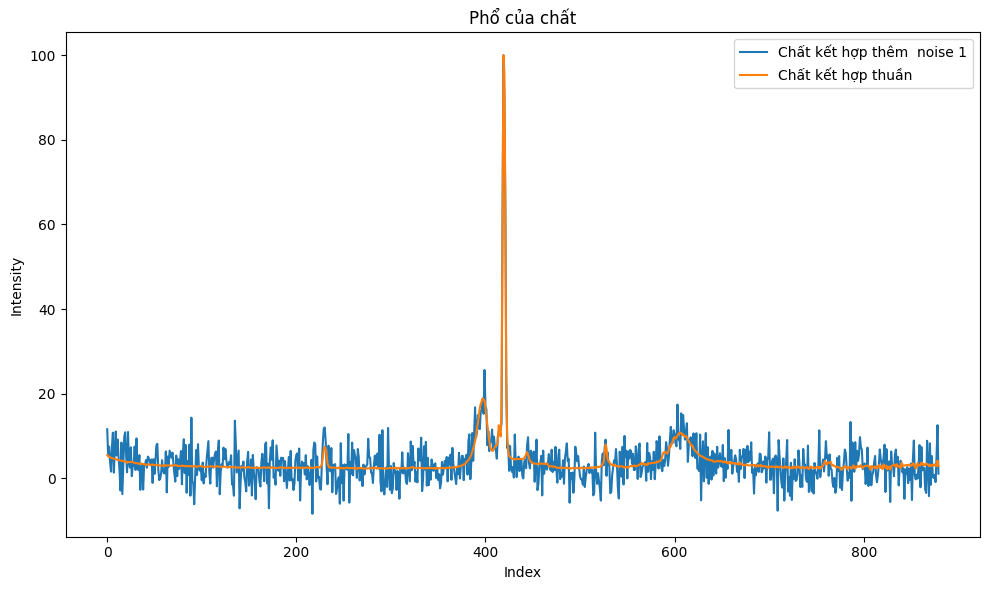

<Figure size 1500x800 with 0 Axes>

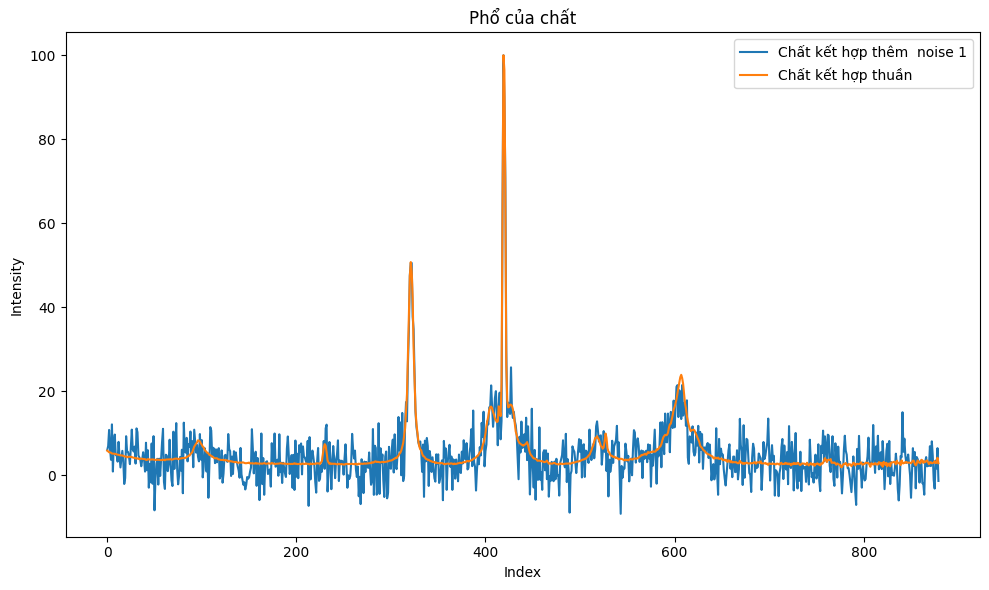

<Figure size 1500x800 with 0 Axes>

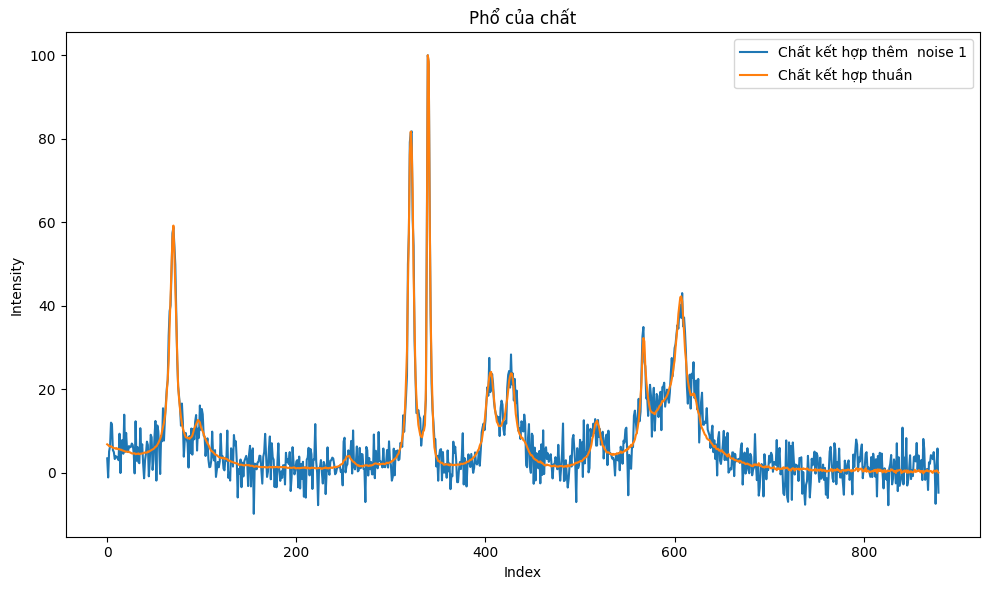

<Figure size 1500x800 with 0 Axes>

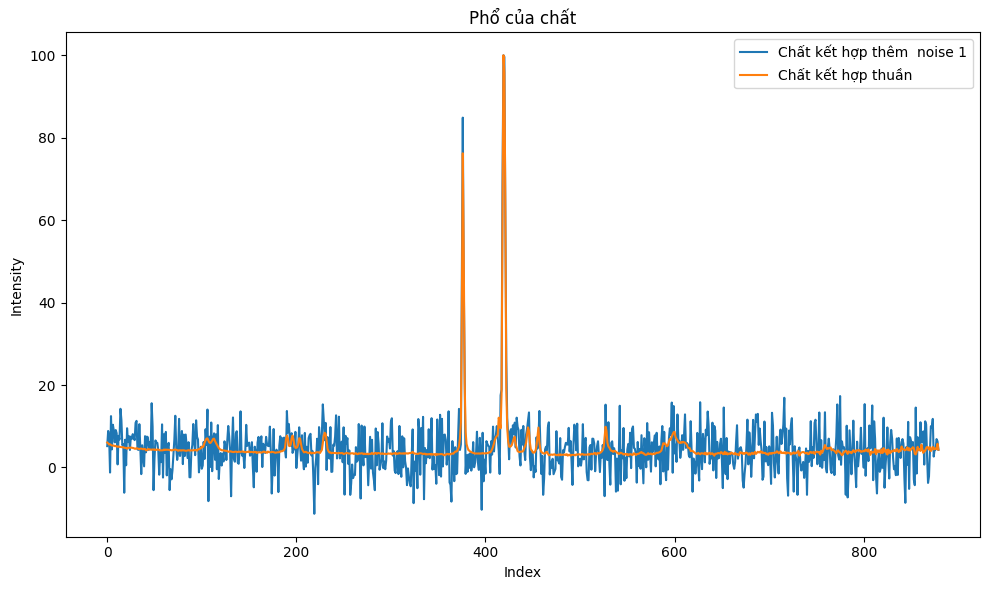

<Figure size 1500x800 with 0 Axes>

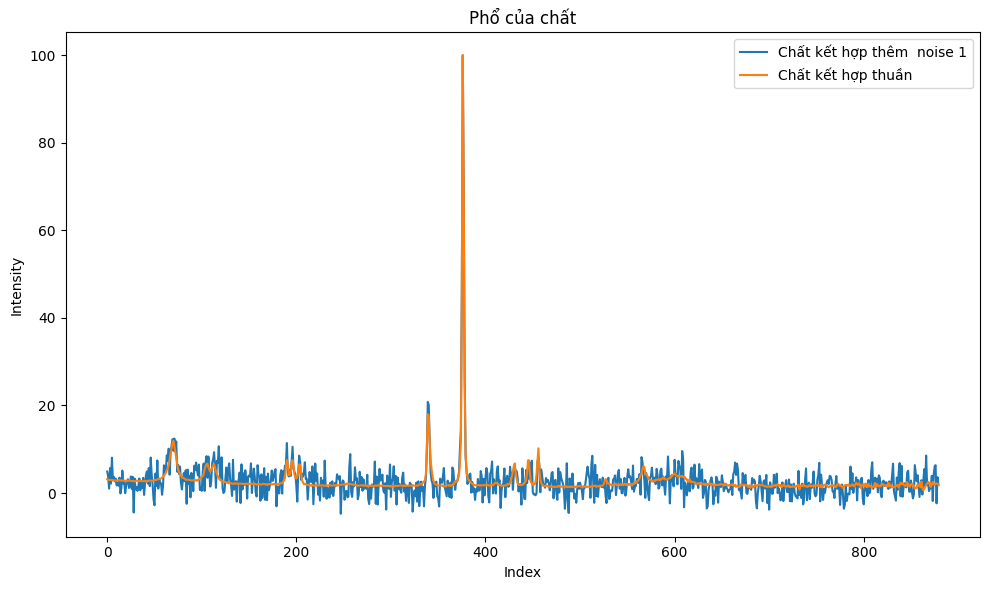

<Figure size 1500x800 with 0 Axes>

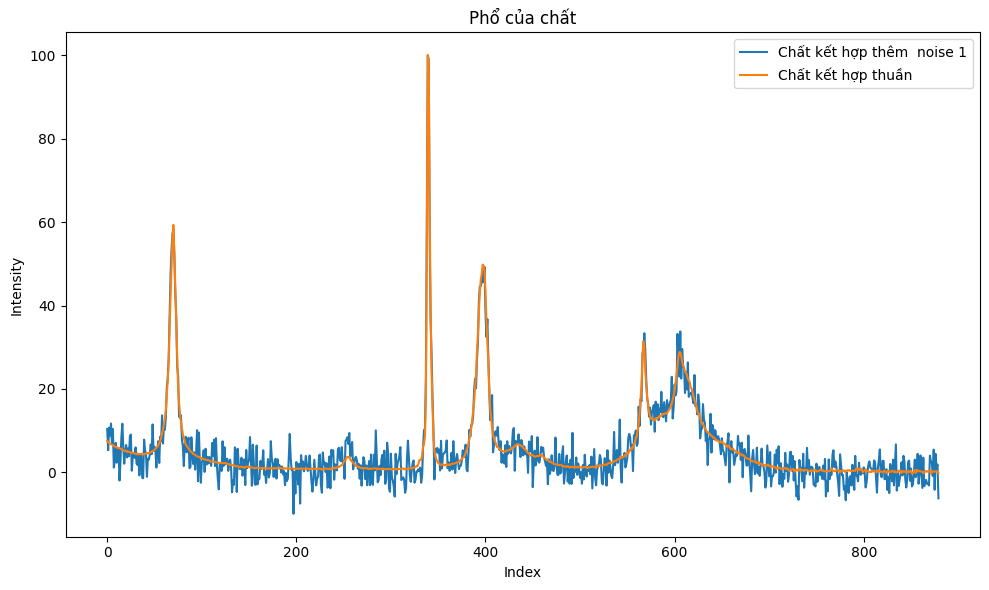

In [14]:
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
# Số mẫu và chất pure cần hiển thị
num_samples_to_display = 6
num_pure_components_to_display = 2


dataset_mix = np.load('./data/dataset_noise_01104.npy')
# Lặp qua từng mẫu
for i in range(num_samples_to_display):
    plt.figure(figsize=(15, 8))
    plt.suptitle(f"Mẫu {i+1}", fontsize=16)
    
    # Lặp qua từng chất pure trong mẫu
    for j in range(1):    
        plt.figure(figsize=(10, 6))
        plt.plot(dataset_mix[i, j, 1, :, :].reshape(-1), label=f"Chất kết hợp thêm  noise {j+1}")
        plt.plot(dataset_mix[i, j, 0, :, :].reshape(-1), label=f"Chất kết hợp thuần")
        plt.xlabel('Index')
        plt.ylabel('Intensity')
        plt.title('Phổ của chất')
        plt.legend()  
        plt.tight_layout()
        plt.show()


# Huấn luyện model

## Train model ResUNet khử nhiễu dao động

In [1]:
! python train.py --epochs 15 --batch-size 32 --optimizer adam --lr 5e-4 --scheduler decay --batch-norm --gpu 0 

/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
2024-04-09 13:14:35.853504: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-09 13:14:36.138420: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-09 13:14:37.077008: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-04-09 13:14:38.447497: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:

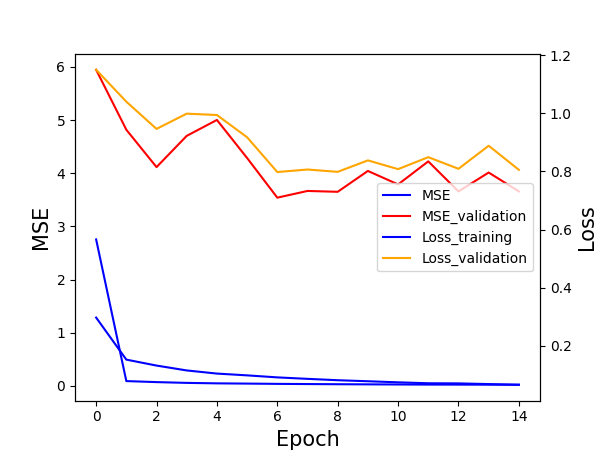

In [2]:
from PIL import Image

# Mở hình ảnh từ tệp PNG
img = Image.open('./plot_model.png')

# Hiển thị hình ảnh
img.show()


# Train model detect

In [1]:
! python train.py --epochs 5 --batch-size 32 --optimizer adam --lr 5e-4 --scheduler decay --batch-norm --gpu 0 --network detect

/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
2024-04-09 10:16:20.592707: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-09 10:16:21.040936: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-09 10:16:22.123734: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-04-09 10:16:23.351794: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:

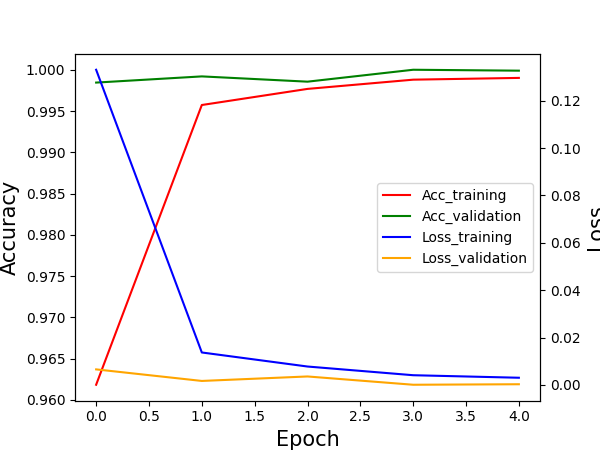

In [6]:
from PIL import Image

# Mở hình ảnh từ tệp PNG
img = Image.open('./plot_detect.png')

# Hiển thị hình ảnh
img.show()


# Test

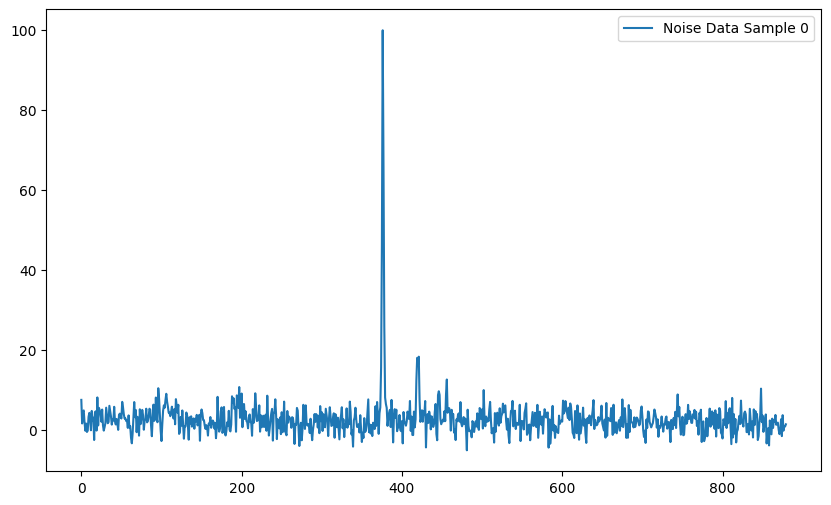

Sample 0:
Spectra may contain (Predicted): 
 [[1.0000000e+00 1.4254315e-12]
 [1.0000000e+00 3.9571500e-08]
 [9.9999988e-01 6.9518670e-08]
 [6.5985540e-26 1.0000000e+00]
 [9.9999547e-01 4.7314666e-06]
 [2.3732771e-10 1.0000000e+00]]
Or spectra may contain (Predicted): 
 [0 0 0 1 0 1]
Spectra real contain (Ground Truth): 
 [0. 0. 0. 1. 0. 1.]
-------------------------------------
Tỷ lệ chuẩn: 
 [0.   0.   0.   0.81 0.   0.19]
Tỷ lệ dự đoán: 
 [0.69326541 0.30673459]


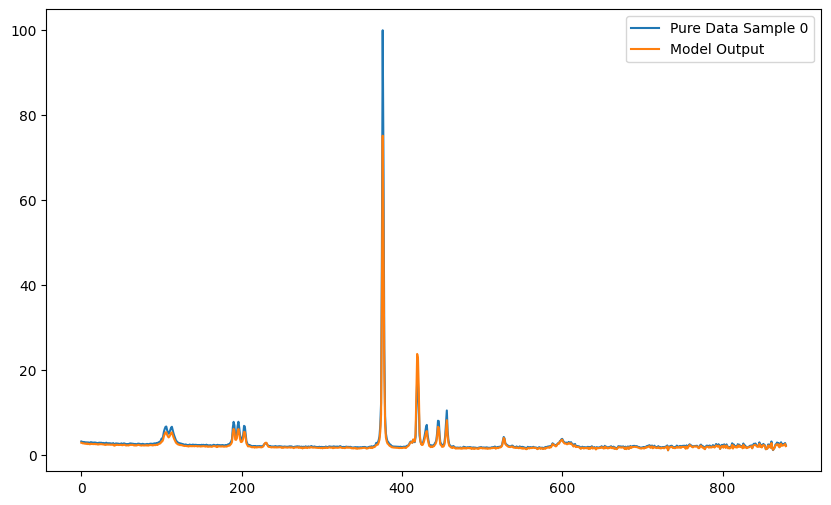

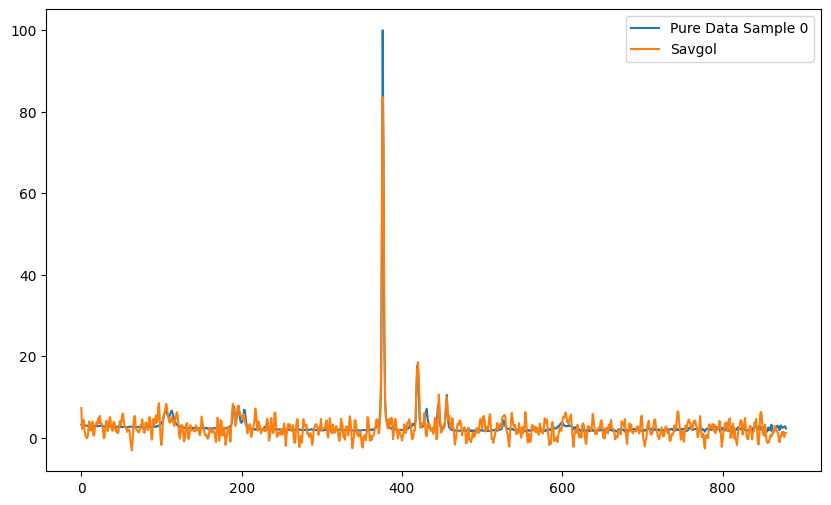

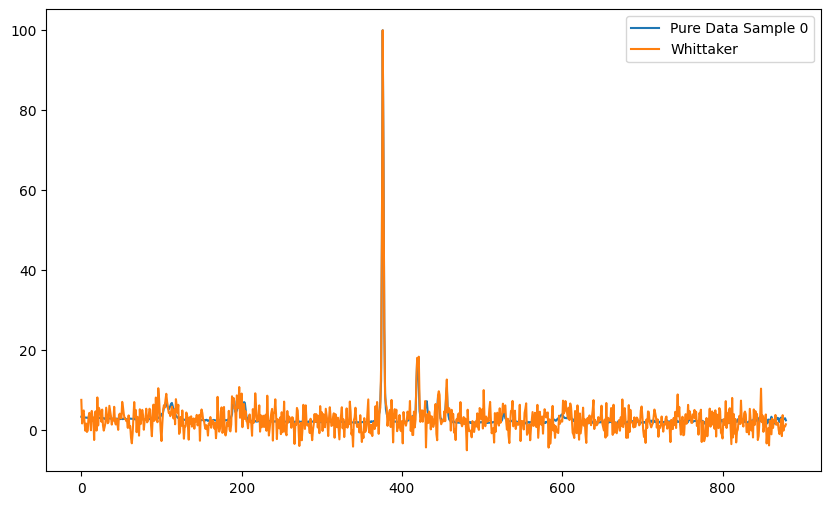

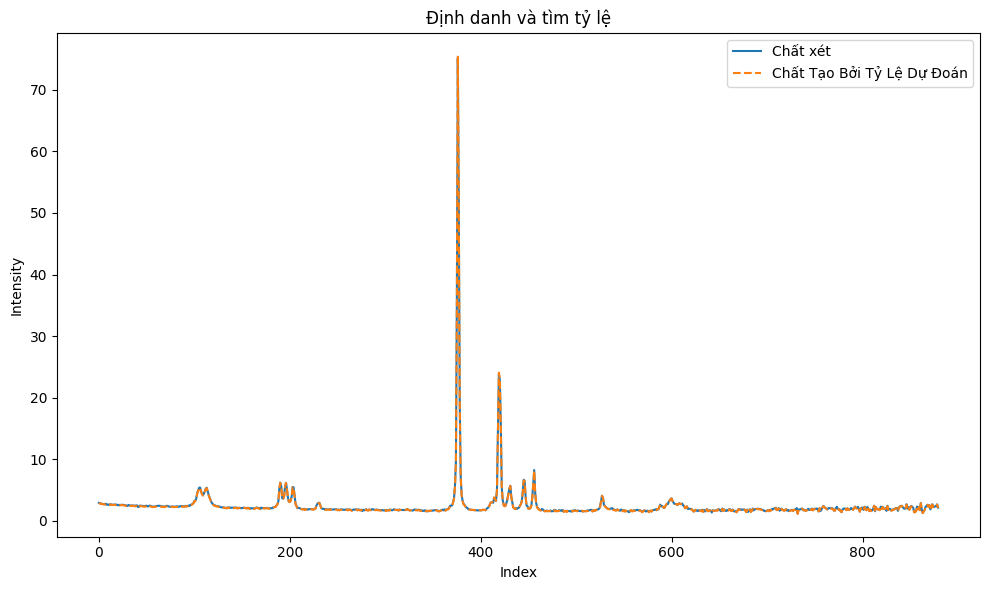

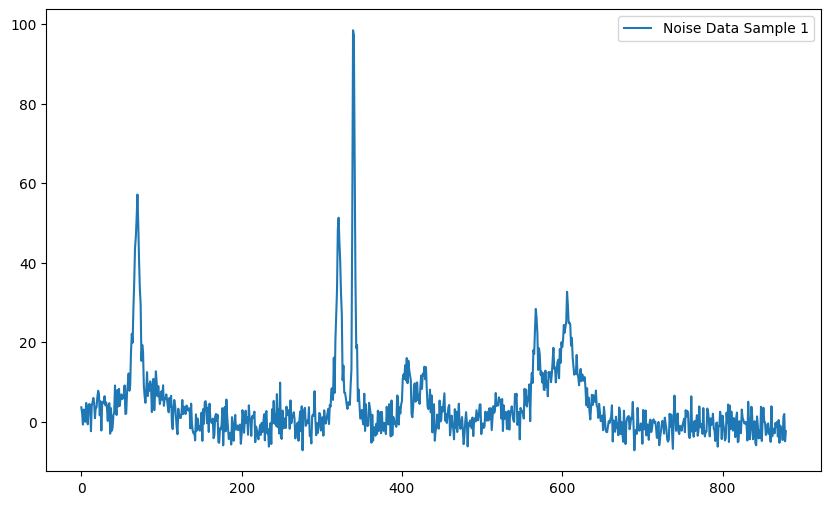

Sample 1:
Spectra may contain (Predicted): 
 [[2.19115292e-22 1.00000000e+00]
 [2.31323835e-10 1.00000000e+00]
 [9.99999881e-01 1.02025645e-07]
 [1.00000000e+00 1.70330665e-08]
 [9.99999642e-01 3.81721946e-07]
 [1.00000000e+00 1.88892257e-09]]
Or spectra may contain (Predicted): 
 [1 1 0 0 0 0]
Spectra real contain (Ground Truth): 
 [1. 1. 0. 0. 0. 0.]
-------------------------------------
Tỷ lệ chuẩn: 
 [0.56 0.44 0.   0.   0.   0.  ]
Tỷ lệ dự đoán: 
 [0.54716874 0.45283126]


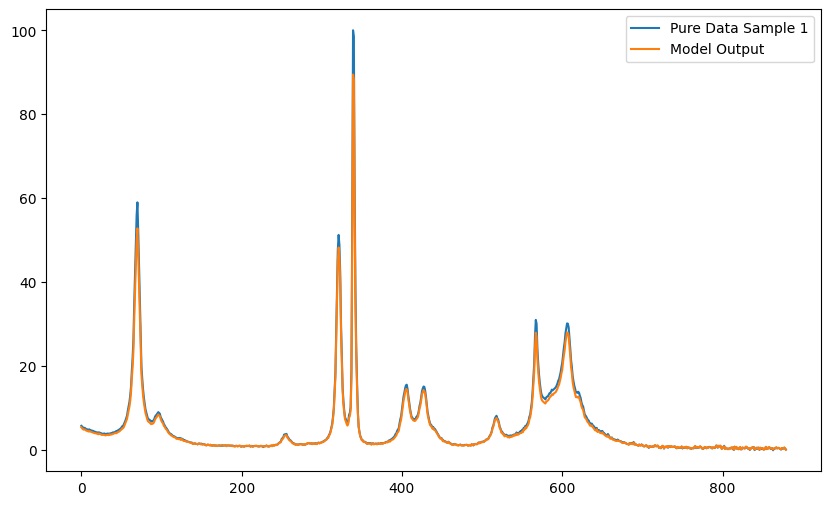

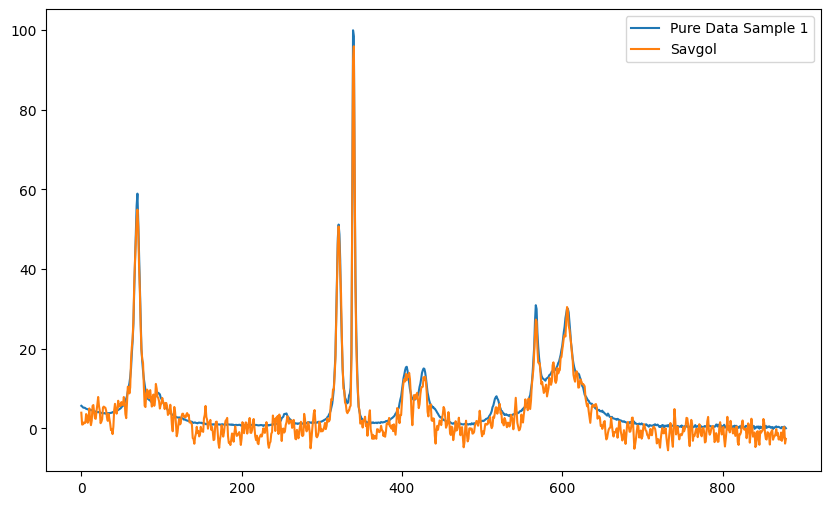

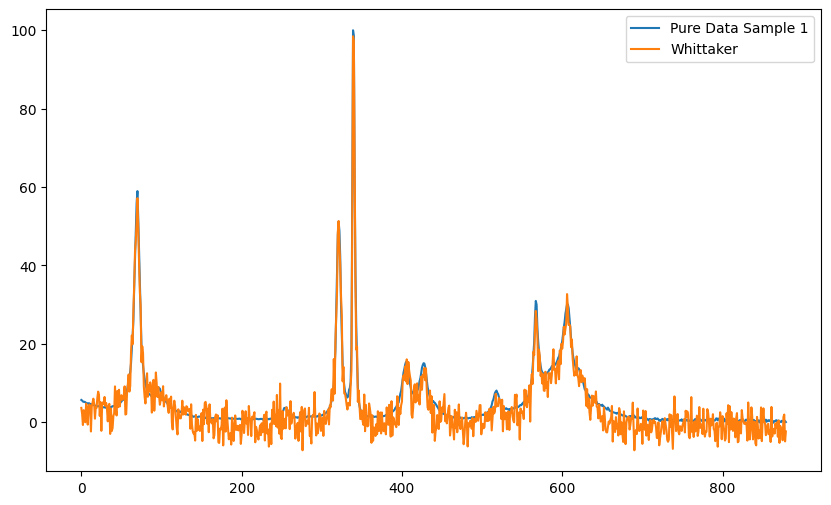

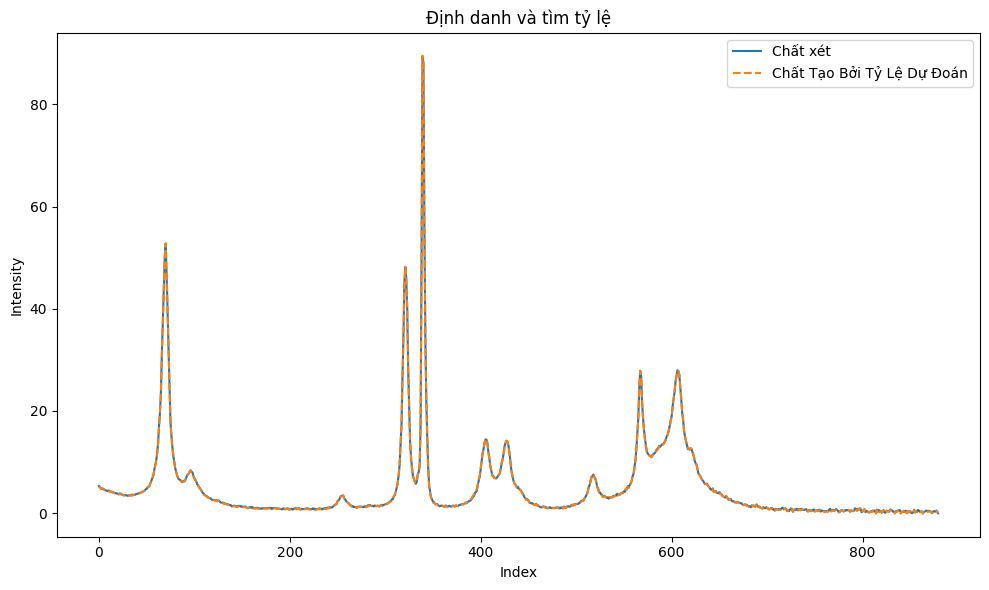

In [25]:
import os
import numpy as np
from Model import SPP, ResUNet
import tensorflow as tf
from scipy.signal import savgol_filter
import csv
import matplotlib.pyplot as plt

num_samples = 1000
num_components = 6
channels = 2
height = 880
width = 1

# Load data test
data = './data'
Input_Data = os.path.join(data, 'dataset_test_01104.npy')
# Có thể thay thê bằng các file our, airPLS, no, IModpoly.npy là file spec đã khử baseline để test
Raw = os.path.join(data, 'our.npy')

Output_Data = os.path.join(data, 'labels_test_01104.npy')
cc_data = os.path.join(data, 'cc_test_01104.npy')
Inputs = np.load(Input_Data)
Raws = np.load(Raw)
ccs = np.load(cc_data)
labels = np.load(Output_Data)
Inputs = Inputs.reshape(-1, Inputs.shape[2], Inputs.shape[3], Inputs.shape[4])
ccs = ccs.reshape(-1, ccs.shape[-1])

Input = Raws
Output = Inputs[:, 0, :, :]

# Số mẫu và chất pure cần hiển thị
num_samples_to_display = 2
num_pure_components_to_display = 2

# Load model ResUNet
model = ResUNet.ResUNet_model()
model.load_weights('./runs/2024_04_09_adam_decay_ResUNet/2024_04_09_adam_decay_ResUNet.weights.h5')

# Load model detect
model_detect =  SPP.SSPmodel()
model_detect.load_weights('./runs/2024_04_09_adam_decay_detect/2024_04_09_adam_decay_detect.weights.h5')
datafile0 = u'./data/database_for_Liquid_and_powder_mixture.npy'
spectrum_pure = spectrum_pure[:,:880]

# # Lặp qua từng mẫu
for j in range(num_samples_to_display):
    # Load các phổ thành phần
    spectrum_pure = np.load(datafile0)
    # Component information of database
    csv_reader = csv.reader(open(u'./data/database_for_Liquid_and_powder_mixture.csv', encoding='utf-8'))
    DBcoms = [row for row in csv_reader]
    
    spectrum_pure = WhittakerSmooth_MAT(spectrum_pure, lamb=1)
    spectrum_pure = airPLS_MAT(spectrum_pure, lamb=10, itermax=10)
    
    # Chuẩn hóa
    for i in range(spectrum_pure.shape[0]):
         spectrum_pure[i, :] = spectrum_pure[i, :] / np.max(spectrum_pure[i, :]) * 100
    spectrum_pure = spectrum_pure[:, :880]
    
    # Test denoising với phổ test
    outs = Input[j, :, :]
    plt.figure(figsize=(10,6))  
    plt.plot(outs, label=f'Noise Data Sample {j}')
    plt.legend()
    plt.show()
    
    pure = Output[j, : , :]
    pure = pure.reshape(-1)
    out_1 = outs.reshape((1, outs.shape[0], outs.shape[1]))
    out_model = model(out_1)
    out_model = np.asarray(out_model).reshape((out_model.shape[1], 1))
    dataset_check = np.zeros((6, channels, height, width))
    
    for n in range(6):
        dataset_check[n, 0, :, :] = spectrum_pure[n].reshape((880,1)) 
        dataset_check[n, 1, :, :] = out_model
    
    # Detect chất
    y = model_detect(dataset_check) 
    
    # Trích xuất nhãn dự đoán trực tiếp
    if isinstance(y, tf.Tensor):  # Kiểm tra xem y có phải là TensorFlow tensor không
        y = y.numpy()  # Chuyển đổi thành mảng NumPy nếu cần
    predicted_labels = np.argmax(y, axis=1)

    print(f'Sample {j}:')
    print('Spectra may contain (Predicted): \n', y)
    print('Or spectra may contain (Predicted): \n', predicted_labels)
    print('Spectra real contain (Ground Truth): \n', labels[j])
    print('-------------------------------------')
    
    for cc in range(1):
        spectrum_pure = np.load(datafile0)[:,:880] * 10

        com = []
        coms = []
        ra2 = []
        for ss in range(0,6):
            if y[ss, 1] >= 0.5:
                com.append(ss % spectrum_pure.shape[0])

        X = spectrum_pure[com]
        coms = [DBcoms[com[h]] for h in range(len(com))]
        out_model = out_model.reshape(1,880,1)
        _, coefs_lasso, _ = enet_path(X.T, out_model[cc, :].squeeze(), l1_ratio=0.96, positive=True)
        
        # Hồi quy bằng hồi quy tuyến tính
        import sklearn.linear_model as linear_model
        # coefs_lasso = linear_model.LinearRegression().fit(X.T, out_model[cc, :]).coef_
        # print(coefs_lasso)
        
        ratio = coefs_lasso[:,-1]
        ratio_sc = copy.deepcopy(ratio)

        for ss2 in range(ratio.shape[0]):
            ratio_sc[ss2] = ratio[ss2] / np.sum(ratio) 
        
        print("Tỷ lệ chuẩn: \n", ccs[j])
        print("Tỷ lệ dự đoán: \n", ratio_sc)
 
    # Spectrum denoise với các phương pháp khác nhau
    plt.figure(figsize=(10,6))  
    plt.plot(pure, label=f'Pure Data Sample {j}')
    plt.plot(out_model[0],label='Model Output')
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(10,6))  
    plt.plot(pure, label=f'Pure Data Sample {j}')
    plt.plot(savgol_filter(outs.reshape(-1), window_length=5, polyorder=3), label='Savgol')
    plt.legend()
    plt.show()
        
    plt.figure(figsize=(10,6))  
    plt.plot(pure, label=f'Pure Data Sample {j}')
    plt.plot(WhittakerSmooth_MAT(outs, lamb=1), label='Whittaker')
    plt.legend()
    plt.show()
   
    # Vẽ biểu đồ cho các chất tạo ra chất cc
    spectrum_cc = np.float64(np.zeros_like(880))
    plt.figure(figsize=(10, 6))
    test = np.zeros(6)
    for i, idx in enumerate(com):
            spectrum_cc += np.float64(ratio[i]) * np.float64(spectrum_pure[idx])
            # plt.plot(ratio[i] * spectrum_pure[idx], label=f"{coms[i]} với tỷ lệ {ratio_sc[i]}")      
            test[idx] = ratio_sc[i]
    plt.plot(out_model[0], label=f"Chất xét")
    plt.plot(spectrum_cc, label=f'Chất Tạo Bởi Tỷ Lệ Dự Đoán', linestyle='--')
    plt.xlabel('Index')
    plt.ylabel('Intensity')
    plt.title('Định danh và tìm tỷ lệ')
    plt.legend()  
    plt.tight_layout()
    plt.show()

# Tính RMSE khử nhiễu dao động trên tập test

In [4]:
import os
import numpy as np
from Model import SPP, ResUNet
from scipy.signal import savgol_filter
import tensorflow as tf
import matplotlib.pyplot as plt

# Định nghĩa hàm tính RMSE
def calculate_rmse(y_true, y_pred):
    """
    Function to calculate Root Mean Squared Error (RMSE)

    Parameters:
    - y_true: numpy array, true values
    - y_pred: numpy array, predicted values

    Returns:
    - rmse: float, RMSE value
    """
    # Reshape y_true_batch để có cùng kích thước với y_pred_batch
    rmse = np.sqrt(np.mean((y_true - y_pred)**2))
    return rmse

# Load dữ liệu
data = './data'
Input_Data = os.path.join(data, 'dataset_test_01104.npy')
Output_Data = os.path.join(data, 'labels_test_01104.npy')
cc_data = os.path.join(data, 'cc_test_01104.npy')
Inputs = np.load(Input_Data)
ccs = np.load(cc_data)
labels = np.load(Output_Data)

# Reshape dữ liệu
Inputs = Inputs.reshape(-1, Inputs.shape[2], Inputs.shape[3], Inputs.shape[4])
Input = Inputs[:, 1, :, :]
Output = Inputs[:, 0, :, :]

# Tạo dataset từ dữ liệu
dataset = tf.data.Dataset.from_tensor_slices((Input, Output)).batch(32)

# Load model
model = ResUNet.ResUNet_model()
model.load_weights('./runs/2024_04_09_adam_decay_ResUNet/2024_04_09_adam_decay_ResUNet.weights.h5')

# Tính toán RMSE trên từng batch và tổng cộng RMSE
num_batches = len(dataset)
total_rmse = 0.0
total_rmse_gov = 0.0
total_Whiter = 0.0

# Lặp qua từng batch trong dataset
for i, batch in enumerate(dataset):
    # Trích xuất nhãn thực tế và dự đoán từ batch
    X_batch, y_true_batch = batch
    y_pred_batch = model.predict(X_batch)
    
    # Tính giá trị lớn nhất trong mỗi batch
    max_values = np.max(y_pred_batch, axis=1, keepdims=True)
    max_values_y = np.max(y_true_batch, axis=1, keepdims=True)
    max_values_X = np.max(X_batch, axis=1, keepdims=True)
    
    # Chia mỗi giá trị trong mỗi batch cho giá trị lớn nhất và nhân với 100
    y_pred_batch = y_pred_batch / max_values
    y_true_batch = y_true_batch / max_values_y
    X_batch = X_batch / max_values_X
    
    # reshape
    X_batch = np.reshape(X_batch, y_pred_batch.shape)
    y_true_batch = np.reshape(y_true_batch, y_pred_batch.shape)
    
    # Áp dụng bộ lọc Savitzky-Golay
    smoothed_input = savgol_filter(X_batch, window_length=5, polyorder=3)
    whittaker_smooth = WhittakerSmooth_MAT(X_batch, lamb=1)
    
    # Tính toán RMSE cho batch
    rmse_batch = calculate_rmse(y_true_batch, y_pred_batch)
    rmse_gov = calculate_rmse(y_true_batch, smoothed_input)
    rmse_Whiter = calculate_rmse(y_true_batch, whittaker_smooth)
    print(f"RMSE batch {i+1}/{num_batches}: {rmse_batch}")
    print(f"RMSE gov: {rmse_gov}")
    print(f"RMSE Whitter: {rmse_Whiter}")
    
    total_rmse += rmse_batch
    total_rmse_gov += rmse_gov
    total_Whiter += rmse_Whiter
    
# Tính toán RMSE trung bình trên toàn bộ dataset
average_rmse = total_rmse / num_batches
average_rmse_gov = total_rmse_gov / num_batches
average_rmse_Whiter = total_Whiter /num_batches
print("Average RMSE on the entire dataset:", average_rmse)
print("Average RRMSE SG:", average_rmse_gov)
print("Average RRMSE Whitter:", average_rmse_Whiter)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
(32, 880, 1)
(32, 880)
RMSE batch 1/10: 0.012585931519807893
RMSE gov: 0.029067018351389244
RMSE Whitter: 0.024363374638598022
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
(32, 880, 1)
(32, 880)
RMSE batch 2/10: 0.011094416734990755
RMSE gov: 0.032806355119184824
RMSE Whitter: 0.027150896687913165
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
(32, 880, 1)
(32, 880)
RMSE batch 3/10: 0.012763076892337277
RMSE gov: 0.029125452710804123
RMSE Whitter: 0.024424788152236893
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
(32, 880, 1)
(32, 880)
RMSE batch 4/10: 0.010400923929240316
RMSE gov: 0.024174256871900654
RMSE Whitter: 0.02112796253967755
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
(32, 880, 1)
(32, 880)
RMSE batch 5/10: 0.01080457074944634
RMSE gov: 0.0291520266323708
RMSE Whitter: 0.02466504367799508
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
(32, 880, 1)
(32, 880)
RMSE batch 6/10: 0.015280753756756991
RMSE gov: 0.030140021305217146
RMSE Whitter: 0.025592914833922904
1/1 ━━━━━━━━━━━━━

2024-04-09 14:00:52.055533: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [24]:
# Load dữ liệu
data = './data'
Input_Data = os.path.join(data, 'dataset_test_01104.npy')
# Có thể thay thê bằng các file our, airPLS, no, IModpoly.npy là file spec đã khử baseline để test
Raw = os.path.join(data, 'our.npy')

Output_Data = os.path.join(data, 'labels_test_01104.npy')
cc_data = os.path.join(data, 'cc_test_01104.npy')
Inputs = np.load(Input_Data)
Raws = np.load(Raw)
ccs = np.load(cc_data)
labels = np.load(Output_Data)
Inputs = Inputs.reshape(-1, Inputs.shape[2], Inputs.shape[3], Inputs.shape[4])
ccs = ccs.reshape(-1, ccs.shape[-1])

Input = Raws
Output = Inputs[:, 0, :, :]
# Tạo dataset từ dữ liệu
dataset = tf.data.Dataset.from_tensor_slices((Input, labels)).batch(32)

# Load model
model = ResUNet.ResUNet_model()
model.load_weights('./runs/2024_04_09_adam_decay_ResUNet/2024_04_09_adam_decay_ResUNet.weights.h5')
model_detect =  SPP.SSPmodel()
model_detect.load_weights('./runs/2024_04_08_adam_decay_detect/2024_04_08_adam_decay_detect.weights.h5')
num_batches = len(dataset)

# Do chinh xac du doan
total_acc = 0.0
total_acc_sg = 0.0
total_acc_wh = 0.0
total_acc_no = 0.0

# RMSE baseline
total_rmse = 0.0
total_rmse_sg = 0.0
total_rmse_wh = 0.0
total_rmse_no = 0.0

# # RMSE denoise
# total_rmse_denoise = 0.0
# total_rmse_gov = 0.0
# total_Whiter = 0.0
j = 0
t =0
for z, (X_batch, y_true_batch) in enumerate(dataset):
    print(f"Batch {z+1}")
    # Do chinh xac du doan batch
    total_acc_batch = 0.0
    total_acc_sg_batch = 0.0
    total_acc_wh_batch = 0.0
    total_acc_no_batch = 0.0
    
    total_rmse_batch = 0.0
    total_rmse_sg_batch = 0.0
    total_rmse_wh_batch = 0.0
    total_rmse_no_batch = 0.0
    p = 0
    for X, y in zip(X_batch, y_true_batch):
            X = np.array(X)
            y = np.array(y)    
            #-----------------------------------------------------------
            
            # TH không khử nhiễu
            spectrum_pure = np.load(datafile0)
            p +=1
    
            # Component information of database
            csv_reader = csv.reader(open(u'./data/database_for_Liquid_and_powder_mixture.csv', encoding='utf-8'))
            DBcoms = [row for row in csv_reader]
            
            
            spectrum_pure = WhittakerSmooth_MAT(spectrum_pure, lamb=1)
            spectrum_pure = airPLS_MAT(spectrum_pure, lamb=10, itermax=10)
             
            for i in range(spectrum_pure.shape[0]):
                 spectrum_pure[i, :] = spectrum_pure[i, :] / np.max(spectrum_pure[i, :]) * 100
            spectrum_pure = spectrum_pure[:, :880]
            out_X = X.reshape((1, X.shape[0], X.shape[1]))
            dataset_check = np.zeros((6, 2, 880, 1))
            for n in range(6):
                dataset_check[n, 0, :, :] = spectrum_pure[n].reshape((880, 1)) 
                dataset_check[n, 1, :, :] = out_X
                
            y_pred = model_detect(dataset_check)
            predicted_classes = np.argmax(y_pred, axis=1)
            
            # Tính acc detect trong TH không khử nhiễu
            if np.array_equal(predicted_classes, y):
                total_acc_no_batch += 1
                
            for cc in range(1):
                spectrum_pure = np.load(datafile0)[:,:880] *10
                com = []
                coms = []
                ra2 = []
                for ss in range(0,6):
                    if np.argmax(y_pred[ss]) == 1:
                        com.append(ss % spectrum_pure.shape[0])
                X = spectrum_pure[com]
                coms = [DBcoms[com[h]] for h in range(len(com))]
                out_X = out_X.reshape(1,880,1)
                # _, coefs_lasso, _ = enet_path(X.T, out_X[cc, :].squeeze(), l1_ratio=0.96, positive=True)
                import sklearn.linear_model as linear_model
                coefs_lasso = linear_model.LinearRegression().fit(X.T, out_X[cc, :]).coef_
                ratio = coefs_lasso[0]
                ratio_sc = copy.deepcopy(ratio)
        
                for ss2 in range(ratio.shape[0]):
                    if np.sum(ratio) == 0:
                        ratio_sc[ss2] =0
                        continue
                    ratio_sc[ss2] = ratio[ss2] / np.sum(ratio) 
            spectrum_cc = np.float64(np.zeros_like(880))
            test_X = np.zeros(6)
            for i, idx in enumerate(com):
                    test_X[idx] = ratio_sc[i]
                    spectrum_cc += np.float64(ratio[i]) * np.float64(spectrum_pure[idx])
    
            # print("Test_X", test_X)
            # Tình RMSE giữa tỷ lệ dự đoán và thực tế với TH không khử nhiễu
            total_rmse_no_batch += calculate_rmse(test_X, ccs[j])
            # print(calculate_rmse(test_X, ccs[j]))
            # plt.plot(spectrum_cc, label=f'Chất Tạo Bởi Tỷ Lệ noise', linestyle='--')
            #-----------------------------------------------------------
            
            # TH khử nhiễu dao động bằng model
            spectrum_pure = np.load(datafile0)
    
            # Component information of database
            csv_reader = csv.reader(open(u'./data/database_for_Liquid_and_powder_mixture.csv', encoding='utf-8'))
            DBcoms = [row for row in csv_reader]
            
            spectrum_pure = WhittakerSmooth_MAT(spectrum_pure, lamb=1)
            spectrum_pure = airPLS_MAT(spectrum_pure, lamb=10, itermax=10)
             
            for i in range(spectrum_pure.shape[0]):
                 spectrum_pure[i, :] = spectrum_pure[i, :] / np.max(spectrum_pure[i, :]) * 100
            spectrum_pure = spectrum_pure[:, :880]
            out_model = model(out_X)
            # out_model = out_model / np.max(out_model) * 100
            out_model = np.asarray(out_model).reshape((1, 880, 1))
            dataset_check = np.zeros((6, 2, 880, 1))
            for n in range(6):
                dataset_check[n, 0, :, :] = spectrum_pure[n].reshape((880, 1))
                dataset_check[n, 1, :, :] = out_model
                
            y_pred = model_detect(dataset_check)
            predicted_classes = np.argmax(y_pred, axis=1)
            if np.array_equal(predicted_classes, y):
                total_acc_batch += 1
                
            for cc in range(1):
                spectrum_pure = np.load(datafile0)[:,:880] *10
        
                com = []
                coms = []
                ra2 = []
                for ss in range(0,6):
                    if np.argmax(y_pred[ss]) == 1:
                        com.append(ss % spectrum_pure.shape[0])
                # print(com)
                X = spectrum_pure[com]
                coms = [DBcoms[com[h]] for h in range(len(com))]
                out_model = out_model.reshape(1,880,1)
                # _, coefs_lasso, _ = enet_path(X.T, out_X[cc, :].squeeze(), l1_ratio=0.96, positive=True)
                import sklearn.linear_model as linear_model
                coefs_lasso = linear_model.LinearRegression().fit(X.T, out_X[cc, :]).coef_
                ratio = coefs_lasso[0]
                ratio_sc = copy.deepcopy(ratio)
        
                for ss2 in range(ratio.shape[0]):
                    if np.sum(ratio) == 0:
                        ratio_sc[ss2] =0
                        continue
                    ratio_sc[ss2] = ratio[ss2] / np.sum(ratio) 
    
            spectrum_cc = np.float64(np.zeros_like(880))
            test_model = np.zeros(6)
            for i, idx in enumerate(com):
                    test_model[idx] = ratio_sc[i]
                    spectrum_cc += np.float64(ratio[i]) * np.float64(spectrum_pure[idx])
    
            # print("Test_model", test_model)
            total_rmse_batch += calculate_rmse(test_model, ccs[j])
            # print(calculate_rmse(test_model, ccs[j]))
            # plt.plot(spectrum_cc, label=f'Chất Tạo Bởi Tỷ Lệ model', linestyle='--')
            #-----------------------------------------------------------
            
            # TH khử nhiễu dao động bằng savgol_filter
            spectrum_pure = np.load(datafile0)
    
            # Component information of database
            csv_reader = csv.reader(open(u'./data/database_for_Liquid_and_powder_mixture.csv', encoding='utf-8'))
            DBcoms = [row for row in csv_reader]
            
            
            spectrum_pure = WhittakerSmooth_MAT(spectrum_pure, lamb=1)
            spectrum_pure = airPLS_MAT(spectrum_pure, lamb=10, itermax=10)
             
            for i in range(spectrum_pure.shape[0]):
                 spectrum_pure[i, :] = spectrum_pure[i, :] / np.max(spectrum_pure[i, :]) * 100
            spectrum_pure = spectrum_pure[:, :880]
            out_sg = np.asarray(savgol_filter(out_X.reshape(-1), window_length=10, polyorder=3)).reshape((880, 1))
            dataset_check = np.zeros((6, 2, 880, 1))
            for n in range(6):
                dataset_check[n, 0, :, :] = spectrum_pure[n].reshape((880, 1)) 
                dataset_check[n, 1, :, :] = out_sg
        
            y_pred = model_detect(dataset_check)
            predicted_classes = np.argmax(y_pred, axis=1)
            if np.array_equal(predicted_classes, y):
                total_acc_sg_batch += 1
            
            for cc in range(1):
                spectrum_pure = np.load(datafile0)[:,:880] *10
        
                com = []
                coms = []
                ra2 = []
                for ss in range(0,6):
                    if np.argmax(y_pred[ss]) == 1:
                        com.append(ss % spectrum_pure.shape[0])
                # print(com)
        
                X = spectrum_pure[com]
                coms = [DBcoms[com[h]] for h in range(len(com))]
                out_sg = out_sg.reshape(1,880,1)
                # _, coefs_lasso, _ = enet_path(X.T, out_X[cc, :].squeeze(), l1_ratio=0.96, positive=True)
                import sklearn.linear_model as linear_model
                coefs_lasso = linear_model.LinearRegression().fit(X.T, out_X[cc, :]).coef_
                ratio = coefs_lasso[0]
                ratio_sc = copy.deepcopy(ratio)
        
                for ss2 in range(ratio.shape[0]):
                    if np.sum(ratio) == 0:
                        ratio_sc[ss2] =0
                        continue
                    ratio_sc[ss2] = ratio[ss2] / np.sum(ratio) 
            spectrum_cc = np.float64(np.zeros_like(880))
            test_sg = np.zeros(6)
            for i, idx in enumerate(com):
                    test_sg[idx] = ratio_sc[i]
                    spectrum_cc += np.float64(ratio[i]) * np.float64(spectrum_pure[idx])
    
            # print("Test_sg", test_sg)
            total_rmse_sg_batch += calculate_rmse(test_sg, ccs[j])
            # print(calculate_rmse(test_sg, ccs[j]))
            # plt.plot(spectrum_cc, label=f'Chất Tạo Bởi Tỷ Lệ sg', linestyle='--')
            # plt.ylabel('Intensity')
            # plt.title('Định danh và tìm tỷ lệ')
            # plt.legend()  
            # plt.tight_layout()
            # plt.show()
            
            #-----------------------------------------------------------
            
            # Khử nhiễu dao động bằng WhittakerSmooth
            spectrum_pure = np.load(datafile0)
    
            # Component information of database
            csv_reader = csv.reader(open(u'./data/database_for_Liquid_and_powder_mixture.csv', encoding='utf-8'))
            DBcoms = [row for row in csv_reader]
            
            
            spectrum_pure = WhittakerSmooth_MAT(spectrum_pure, lamb=1)
            spectrum_pure = airPLS_MAT(spectrum_pure, lamb=10, itermax=10)
             
            for i in range(spectrum_pure.shape[0]):
                 spectrum_pure[i, :] = spectrum_pure[i, :] / np.max(spectrum_pure[i, :]) * 100
            spectrum_pure = spectrum_pure[:, :880]
            out_whiter = np.asarray(WhittakerSmooth_MAT(out_X.reshape(880,1), lamb=1)).reshape((880, 1))
            dataset_check = np.zeros((6, 2, 880, 1))
            for n in range(6):
                dataset_check[n, 0, :, :] = spectrum_pure[n].reshape((880, 1)) 
                dataset_check[n, 1, :, :] = out_whiter
        
            y_pred = model_detect(dataset_check)
            predicted_classes = np.argmax(y_pred, axis=1)
            if np.array_equal(predicted_classes, y):
                total_acc_wh_batch += 1
                
            for cc in range(1):
                spectrum_pure = np.load(datafile0)[:,:880] *10
        
                com = []
                coms = []
                ra2 = []
                for ss in range(0,6):
                    if y_pred[ss, 1] >= 0.5:
                        com.append(ss % spectrum_pure.shape[0])
        
                X = spectrum_pure[com]
                coms = [DBcoms[com[h]] for h in range(len(com))]
                out_whiter = out_whiter.reshape(1,880,1)
                # _, coefs_lasso, _ = enet_path(X.T, out_X[cc, :].squeeze(), l1_ratio=0.96, positive=True)
                import sklearn.linear_model as linear_model
                coefs_lasso = linear_model.LinearRegression(positive=True).fit(X.T, out_X[cc, :]).coef_
                ratio = coefs_lasso[0]
                ratio_sc = copy.deepcopy(ratio)
        
                for ss2 in range(ratio.shape[0]):
                    if np.sum(ratio) == 0:
                        ratio_sc[ss2] =0
                        continue
                    ratio_sc[ss2] = ratio[ss2] / np.sum(ratio) 
                
            test_whiter = np.zeros(6)
            for i, idx in enumerate(com):
                    test_whiter[idx] = ratio_sc[i]
            # print("Test_whiter", test_whiter)
            total_rmse_wh_batch += calculate_rmse(test_whiter, ccs[j])
            # print(calculate_rmse(test_whiter, ccs[j]))
            #-----------------------------------------------------------
            # print(ccs[j])
            # print(j)
            j+=1
            # print(f"Test {j}/{300}: Accuracy No Modification {total_acc_no_batch}, Accuracy Savgol {total_acc_sg_batch}, Accuracy Whittaker {total_acc_wh_batch}, Accuracy {total_acc_batch}")
            # 
            # print(f"Test {j}/{300}: RMSE No Modification {total_rmse_no_batch}, RMSE Savgol {total_rmse_sg_batch}, RMSE Whittaker {total_rmse_wh_batch}, Accuracy {total_rmse_batch}")
            # print("----")
        
    total_acc += total_acc_batch / p
    total_acc_sg += total_acc_sg_batch / p
    total_acc_wh += total_acc_wh_batch / p
    total_acc_no += total_acc_no_batch / p
    
    total_rmse += total_rmse_batch / p
    total_rmse_wh += total_rmse_wh_batch  / p
    total_rmse_no += total_rmse_no_batch  / p
    total_rmse_sg += total_rmse_sg_batch  / p
    if p!=0:
        t+=1
        
    print(f"Batch {z + 1}/{num_batches}: Accuracy No Modification {total_acc_no_batch/p}, Accuracy Savgol {total_acc_sg_batch/p}, Accuracy Whittaker {total_acc_wh_batch/p}, Accuracy {total_acc_batch/p}")
    # print(f"Batch {z + 1}/{num_batches}: Total Accuracy No Modification {total_acc_no}, Total Accuracy Savgol {total_acc_sg}, Total Accuracy Whittaker {total_acc_wh}, Total Accuracy {total_acc}")
    print(f"Batch {z + 1}/{num_batches}: RMSE No Modification {total_rmse_no_batch/p}, RMSE Savgol {total_rmse_sg_batch/p}, RMSE Whittaker {total_rmse_wh_batch/p}, RMSE {total_rmse_batch/p}")
    # print(f"Batch {z + 1}/{num_batches}: Total RMSE No Modification {total_rmse_no}, Total RMSE Savgol {total_rmse_sg}, Total RMSE Whittaker {total_rmse_wh}, Total RMSE {total_rmse}")
    
    print("---------------------------------------------------")

average_acc = total_acc / t
average_acc_sg = total_acc_sg / t
average_acc_wh = total_acc_wh / t
average_acc_no = total_acc_no / t

average_rmse = total_rmse / t
average_rmse_sg = total_rmse_sg / t
average_rmse_wh = total_rmse_wh / t
average_rmse_no = total_rmse_no / t

# Trung bình độ chính xác xác định chất
print("Average Accuracy No Modification on the entire dataset:", average_acc_no)
print("Average Accuracy Savgol on the entire dataset:", average_acc_sg)
print("Average Accuracy Whittaker on the entire dataset:", average_acc_wh)
print("Average Accuracy on the entire dataset:", average_acc)

# Trung bình sai số xác định nồng độ
print("Average RMSE No Modification on the entire dataset:", average_rmse_no)
print("Average RMSE Savgol on the entire dataset:", average_rmse_sg)
print("Average RMSE Whittaker on the entire dataset:", average_rmse_wh)
print("Average RMSE on the entire dataset:", average_rmse)

Batch 1
Batch 1/10: Accuracy No Modification 0.78125, Accuracy Savgol 1.0, Accuracy Whittaker 0.78125, Accuracy 0.9375
Batch 1/10: RMSE No Modification 0.009357964066042567, RMSE Savgol 0.007385163022592601, RMSE Whittaker 0.008029971573649099, RMSE 0.011101609287021395
---------------------------------------------------
Batch 2
Batch 2/10: Accuracy No Modification 0.59375, Accuracy Savgol 0.875, Accuracy Whittaker 0.59375, Accuracy 0.96875
Batch 2/10: RMSE No Modification 0.01359398203861101, RMSE Savgol 0.011987681920690663, RMSE Whittaker 0.011432172775622565, RMSE 0.0119477793424444
---------------------------------------------------
Batch 3
Batch 3/10: Accuracy No Modification 0.59375, Accuracy Savgol 0.9375, Accuracy Whittaker 0.59375, Accuracy 0.84375
Batch 3/10: RMSE No Modification 0.016488726407129742, RMSE Savgol 0.010072658981834178, RMSE Whittaker 0.010958570377276872, RMSE 0.02209520656530958
---------------------------------------------------
Batch 4
Batch 4/10: Accuracy

2024-06-22 02:30:38.395813: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [12]:

# import os
# import numpy as np
# from Model import DeepRaman, ResUNet
# from scipy.signal import savgol_filter
# import tensorflow as tf
# import matplotlib.pyplot as plt
# 
# # Định nghĩa hàm tính RMSE
# def calculate_rmse(y_true, y_pred):
#     """
#     Function to calculate Root Mean Squared Error (RMSE)
# 
#     Parameters:
#     - y_true: numpy array, true values
#     - y_pred: numpy array, predicted values
# 
#     Returns:
#     - rmse: float, RMSE value
#     """
#     # Reshape y_true_batch để có cùng kích thước với y_pred_batch
#     rmse = np.sqrt(np.mean((y_true - y_pred)**2))
#     return rmse
# 
# # Load dữ liệu
# # data = './data'
# # Input_Data = os.path.join(data, 'dataset_test_01104.npy')
# # Output_Data = os.path.join(data, 'labels_test_01104.npy')
# # cc_data = os.path.join(data, 'cc_test_01104.npy')
# # Inputs = np.load(Input_Data)
# # ccs = np.load(cc_data)
# # labels = np.load(Output_Data)
# # 
# # # Reshape dữ liệu
# # Inputs = Inputs.reshape(-1, Inputs.shape[2], Inputs.shape[3], Inputs.shape[4])
# # Input = Inputs[:, 1, :, :]
# # Output = Inputs[:, 0, :, :]
# # # Tạo dataset từ dữ liệu
# dataset = tf.data.Dataset.from_tensor_slices((Input, labels)).batch(32)
# 
# # Load model
# model = ResUNet.ResUNet_model()
# model.load_weights('./runs/2024_04_09_adam_decay_ResUNet/2024_04_09_adam_decay_ResUNet.weights.h5')
# model_detect =  DeepRaman.SSPmodel()
# model_detect.load_weights('./runs/2024_04_08_adam_decay_detect/2024_04_08_adam_decay_detect.weights.h5')
# num_batches = len(dataset)
# 
# # Do chinh xac du doan
# total_acc = 0.0
# total_acc_sg = 0.0
# total_acc_wh = 0.0
# total_acc_no = 0.0
# 
# # RMSE baseline
# total_rmse = 0.0
# # total_rmse_airPLS = 0.0
# # total_rmse_IModpoly = 0.0
# # total_rmse_noModify = 0.0
# 
# # # RMSE denoise
# # total_rmse_denoise = 0.0
# # total_rmse_gov = 0.0
# # total_Whiter = 0.0
# 
# spectrum_pure = spectrum_pure[:,:880]
# for i, (X_batch, y_true_batch) in enumerate(dataset):
#     print(f"Batch {i+1}")
#     # Do chinh xac du doan batch
#     total_acc_batch = 0.0
#     total_acc_sg_batch = 0.0
#     total_acc_wh_batch = 0.0
#     total_acc_no_batch = 0.0
#     
#     for X, y in zip(X_batch, y_true_batch):
#         X = np.array(X)
#         y = np.array(y)
#         spectrum_pure = np.load(datafile0)
#         spectrum_pure = spectrum_pure[:, :880]
#         out_X = X.reshape((1, X.shape[0], X.shape[1]))
#         out_model = model(out_X)
#         # out_model = out_model / np.max(out_model) * 100
#         
#         dataset_check = np.zeros((6, 2, 880, 1))
#         for n in range(6):
#             dataset_check[n, 0, :, :] = spectrum_pure[n].reshape((880, 1)) 
#             dataset_check[n, 1, :, :] = out_X
#             
#         y_pred = model_detect(dataset_check)
#         predicted_classes = np.argmax(y_pred, axis=1)
#         if np.array_equal(predicted_classes, y):
#             total_acc_no_batch += 1
#             
#         out_test = np.asarray(out_model).reshape((1, 880, 1))
#         dataset_check = np.zeros((6, 2, 880, 1))
#         for n in range(6):
#             dataset_check[n, 0, :, :] = spectrum_pure[n].reshape((880, 1))
#             dataset_check[n, 1, :, :] = out_test
#             
#         y_pred = model_detect(dataset_check)
#         predicted_classes = np.argmax(y_pred, axis=1)
#         if np.array_equal(predicted_classes, y):
#             total_acc_batch += 1
#             
#         out_sg = np.asarray(savgol_filter(out_X.reshape(-1), window_length=5, polyorder=3)).reshape((880, 1))
#         dataset_check = np.zeros((6, 2, 880, 1))
#         for n in range(6):
#             dataset_check[n, 0, :, :] = spectrum_pure[n].reshape((880, 1)) 
#             dataset_check[n, 1, :, :] = out_sg
#     
#         y_pred = model_detect(dataset_check)
#         predicted_classes = np.argmax(y_pred, axis=1)
#         if np.array_equal(predicted_classes, y):
#             total_acc_sg_batch += 1
#         
#       
#         out_whiter = np.asarray(WhittakerSmooth_MAT(out_X.reshape(880,1), lamb=1)).reshape((880, 1))
#         dataset_check = np.zeros((6, 2, 880, 1))
#         for n in range(6):
#             dataset_check[n, 0, :, :] = spectrum_pure[n].reshape((880, 1)) 
#             dataset_check[n, 1, :, :] = out_whiter
#     
#         y_pred = model_detect(dataset_check)
#         predicted_classes = np.argmax(y_pred, axis=1)
#         if np.array_equal(predicted_classes, y):
#             total_acc_wh_batch += 1
#             
#     total_acc += total_acc_batch / len(X_batch)
#     total_acc_sg += total_acc_sg_batch / len(X_batch)
#     total_acc_wh += total_acc_wh_batch / len(X_batch)
#     total_acc_no += total_acc_no_batch / len(X_batch)
#     
#     print(f"Batch {i + 1}/{num_batches}: Accuracy No Modification {total_acc_no_batch/len(X_batch)}, Accuracy Savgol {total_acc_sg_batch/len(X_batch)}, Accuracy Whittaker {total_acc_wh_batch/len(X_batch)}, Accuracy {total_acc_batch/len(X_batch)}")
#     print(f"Batch {i + 1}/{num_batches}: Total Accuracy No Modification {total_acc_no}, Total Accuracy Savgol {total_acc_sg}, Total Accuracy Whittaker {total_acc_wh}, Total Accuracy {total_acc}")
#     print("---------------------------------------------------")
# 
# average_acc = total_acc / num_batches
# average_acc_sg = total_acc_sg / num_batches
# average_acc_wh = total_acc_wh / num_batches
# average_acc_no = total_acc_no / num_batches
# 
# print("Average Accuracy No Modification on the entire dataset:", average_acc_no)
# print("Average Accuracy Savgol on the entire dataset:", average_acc_sg)
# print("Average Accuracy Whittaker on the entire dataset:", average_acc_wh)
# print("Average Accuracy on the entire dataset:", average_acc)

0.024575255916620346
